<h1><b>Оценка количества одновременных соединений с документами.</b><h1>

<div class="alert alert-info">
<b> Подготовка данных</b>    
</div>

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st
import seaborn as sns
from itertools import combinations
import plotly.express as px
import datetime
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [37]:
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [38]:
data = pd.read_csv('C:/Users/gatsko.veronika/Desktop/bitrix_test/task_data_csv.csv')
data['start_edit_time'] = pd.to_datetime(data['start_edit_time']) 
data['conn_end_time'] = pd.to_datetime(data['conn_end_time']) 
data['day_start'] = data['start_edit_time'].dt.date
data['day_start'] = pd.to_datetime(data['day_start']) 
data['hour_start'] = data['start_edit_time'].dt.floor('H')
data['hour_start'] = pd.to_datetime(data['hour_start']) 
data['start_edit_time'].dt.date.value_counts()

2022-12-05    53041
2022-12-06    50362
2022-12-04       81
Name: start_edit_time, dtype: int64

За 2022-12-04 данных для оценки недостаточно.<br>
Будем работать с данными за 2022-12-06 и 2022-12-05


In [39]:
day_1 = data[data['start_edit_time'].dt.date == datetime.date(2022, 12, 5)]
day_2 = data[data['day_start'].dt.date == datetime.date(2022, 12, 6)]
day_3 = data[data['start_edit_time'].dt.date == datetime.date(2022, 12, 4)]

<div class="alert alert-info">
<b>Анализ данных</b><br><br>
    Чтобы оценить, сколько в пиковые моменты потребления происходит одновременных соединений агрегируем количество пользователей онлайн поминутно. То есть посчитаем количество активных пользователей в каждую минуту времени.<br> Это количество состоит из тех, кто подключился в каждую конкретную минуту времени и тех, кто подключился ранее, но все еще онлайн. 
</div>

In [41]:
test_day_2 = day_2

In [42]:
#для 2022-12-06


# установить индекс на столбец start_edit_time
test_day_2.set_index('start_edit_time', inplace=True)

# создать Series, содержащий индекс со всеми минутами в периоде данных
idx = pd.date_range(start = test_day_2.index.min().floor('T'), end=test_day_2['conn_end_time'].max().ceil('T'), freq='T')
active_users = pd.Series(index=idx, dtype=int)

# перебрать каждую минуту и подсчитать активных пользователей
for minute in active_users.index:
    # выбрать строки, которые перекрываются с текущей минутой
    mask = (test_day_2.index <= minute) & (test_day_2['conn_end_time'] > minute)
    # подсчитать количество уникальных пользователей в этих строках
    active_users[minute] = test_day_2.loc[mask, 'user'].nunique()

active_users = active_users.reset_index()

In [43]:
c = active_users
day_2_final = c.rename(columns={'index': 'datetime', 0: 'users'})
day_2_final = day_2_final[day_2_final['datetime'].dt.date == datetime.date(2022, 12, 6)]

In [44]:
test_day_1 = day_1

In [45]:
#для 2022-12-05

# установить индекс на столбец start_edit_time
test_day_1.set_index('start_edit_time', inplace=True)

# создать Series, содержащий индекс со всеми минутами в периоде данных
idx = pd.date_range(start = test_day_1.index.min().floor('T'), end=test_day_1['conn_end_time'].max().ceil('T'), freq='T')
active_users = pd.Series(index=idx, dtype=int)

# перебрать каждую минуту и подсчитать активных пользователей
for minute in active_users.index:
    # выбрать строки, которые перекрываются с текущей минутой
    mask = (test_day_1.index <= minute) & (test_day_1['conn_end_time'] > minute)
    # подсчитать количество уникальных пользователей в этих строках
    active_users[minute] = test_day_1.loc[mask, 'user'].nunique()

active_users_d1 = active_users.reset_index()

In [46]:
day_1_final = active_users_d1
day_1_final = day_1_final.rename(columns={'index': 'datetime', 0: 'users'})
day_1_final = day_1_final[day_1_final['datetime'].dt.date == datetime.date(2022, 12, 5)]

In [47]:
day_1_final['time'] = pd.to_datetime(day_1_final['datetime']).dt.time
day_2_final['time'] = pd.to_datetime(day_2_final['datetime']).dt.time

In [48]:
data_merge = day_1_final.merge(day_2_final, on='time', how='left')
data_merge = data_merge.rename(columns={'datetime_x': 'datetime_1', 'users_x': 'users_1',  'datetime_y': 'datetime_2', 'users_y': 'users_2'})

In [49]:
fig = go.Figure()

# создаем объект trace1 для df1
trace1 = go.Scatter(x=data_merge['time'], y=data_merge['users_1'], name='05-12-2022')

# создаем объект trace2 для df2
trace2 = go.Scatter(x=data_merge['time'], y=data_merge['users_2'], name='06-12-2022')

# добавляем объекты trace в fig
fig.add_trace(trace1)
fig.add_trace(trace2)

# добавляем оси x и y
fig.update_layout(title='Количество сессий пользователей 5 и 6 декабря', xaxis_title='Время', yaxis_title='Количество сессий', xaxis=dict(tickangle=45))

# отображаем график
fig.show()

<div class="alert alert-info">
На гистограмме видно, что наибольшая активность пользователей наблюдается с 10 до 16 часов. <br>

Максимальная нагрузка 5 декабря наблюдается в 11:56 и составляет 1760 подключений. <br>
Максимальная нагрузка 6 декабря наблюдается в 15:54 и составляет 1554 подключения.
</div>

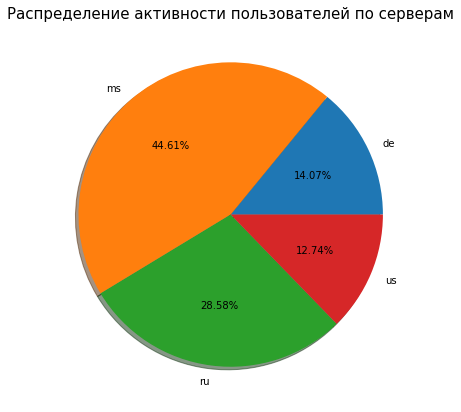

In [50]:
day_1.groupby(['server']).count()['user'].plot(kind='pie', figsize=(15, 7), autopct='%1.2f%%', shadow=True);
plt.title("Распределение активности пользователей по серверам", fontsize=15);
plt.axis('off');

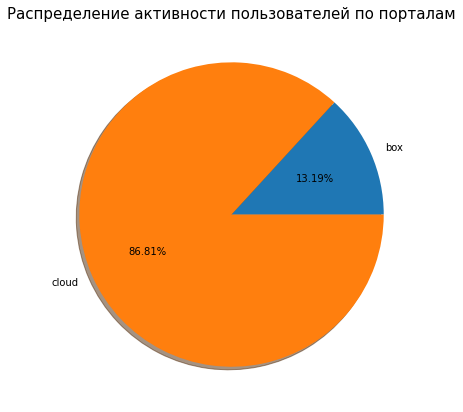

In [51]:
day_1.groupby(['portal_type']).count()['user'].plot(kind='pie', figsize=(15, 7), autopct='%1.2f%%', shadow=True);
plt.title("Распределение активности пользователей по порталам", fontsize=15);
plt.axis('off');

Text(0.5, 0, 'тариф')

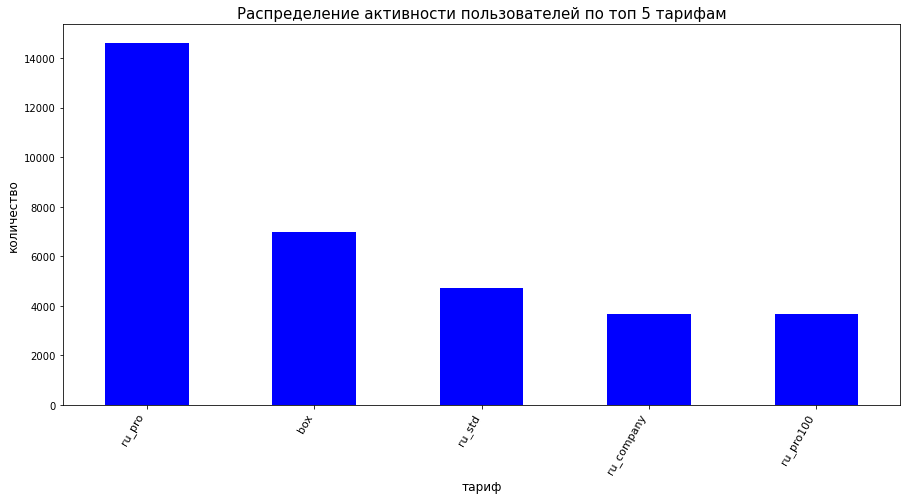

In [52]:
top_5_tariffs = day_1.groupby(['tariff_id']).count()['user'].nlargest(5)

# построить график только для топ 5 тарифов
top_5_tariffs.plot(kind='bar', figsize=(15, 7), color='blue')
plt.title("Распределение активности пользователей по топ 5 тарифам", fontsize=15)
plt.xticks(rotation=60, horizontalalignment='right', fontsize=11)
plt.ylabel('количество', fontsize=12)
plt.xlabel('тариф', fontsize=12)

<b>Вывод:</b> <br>Исходя из анализа данных о максимальном количестве одновременных подключений в самые нагруженные промежутки дня, можно сказать, что имеющихся возможностей (не более 3000 одновременных подключений) достаточно для обеспечения текущих потребностей пользователей. <br>
В предоставленных для анализа данных максимальное количество одновременных подключений составляет 1760 (5 декабря в 11:56)

<br>
Имеющихся возможностей будет достаточно для прироста количества одновременно работающих с документами пользователей.
<br><br>

Если появится необходимость уменьшить количество одновременных подключений к документам начать стоит с самых загруженных, на текущий момент это: 
<ul>
<li>сервер  - ms</li>
<li>тип портала -  cloud</li>
<li>тариф - ru_pro</li>
</ul>